In [1]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta

import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

In [2]:
# Load your CSVs
orders_df = pd.read_csv("orders_data.csv")
customers_df = pd.read_csv("customers_data.csv")
products_df = pd.read_csv("products_data.csv")

In [3]:
# Merge to get location
orders_merged = orders_df.merge(customers_df[['customer_id', 'location']], on='customer_id', how='left')

# Filter for completed orders
# completed_orders = orders_merged[orders_merged['status'] == 'Completed'].copy()
completed_orders = orders_merged.copy()

In [4]:
orders_merged.groupby(by=['status','fulfillment']).count()

,,order_id,customer_id,order_date,product_id,size,location
status,fulfillment,,,,,,
Completed,True,5235,5235,5235,5235,4611,5235
Requested,False,7199,7199,7199,7199,5024,7199
Returned,True,310,310,310,310,284,310


In [5]:
# Define adjacent states where rare in-store visits may happen
adjacent_states = ['RI', 'CT', 'NH', 'VT']

# Assign order channel: online or in-store
def classify_channel(row):
    if row['location'] == 'MA':
        return 'in-store' if np.random.rand() < 0.40 else 'online'
    elif row['location'] in adjacent_states:
        return 'in-store' if np.random.rand() < 0.05 else 'online'
    else:
        return 'online'

completed_orders['channel'] = completed_orders.apply(classify_channel, axis=1)


In [6]:
completed_orders.head()

,order_id,customer_id,order_date,product_id,size,status,fulfillment,location,channel
0,162,1070,2019-01-12,73,L,Completed,True,FL,online
1,475,783,2019-02-01,249,L,Completed,True,TX,online
2,475,783,2019-02-01,67,S,Completed,True,TX,online
3,532,839,2019-02-05,249,XL,Completed,True,MA,online
4,605,1061,2019-02-09,249,M,Returned,True,FL,online


In [7]:
completed_orders[completed_orders['channel']=='online']['customer_id'].nunique()

1059

In [98]:
completed_orders[completed_orders['channel']=='online']['order_id'].nunique()

6398

In [8]:
completed_orders.drop_duplicates(subset=['order_id','customer_id','channel']).groupby(by=['channel']).count()

,order_id,customer_id,order_date,product_id,size,status,fulfillment,location
channel,,,,,,,,
in-store,1490,1490,1490,1490,1142,1490,1490,1490
online,6458,6458,6458,6458,4980,6458,6458,6458


In [9]:
# Define traffic source weights by order date
def get_source_weights(order_date):
    if order_date < pd.Timestamp("2024-08-15"):
        return ['google', 'instagram', 'email'], [0.6, 0.15, 0.25]
    elif pd.Timestamp("2024-08-15") <= order_date <= pd.Timestamp("2024-10-10"):
        return ['google', 'instagram', 'email'], [0.5, 0.2, 0.3]
    else:
        return ['google', 'instagram', 'email'], [0.4, 0.25, 0.35]


In [10]:
# Step 1: Revenue by Month
orders_with_price = completed_orders.merge(products_df[['product_id', 'price']].drop_duplicates(), on='product_id', how='left')
orders_with_price["order_month"] = pd.to_datetime(orders_with_price["order_date"]).dt.to_period("M").astype(str)

monthly_revenue = (
    orders_with_price[orders_with_price["channel"] == "online"]
    .groupby("order_month")
    .agg(revenue=("price", "sum"), order_count=("order_id", "nunique"))
    .reset_index()
    .rename(columns={"order_month": "month"})
)
monthly_revenue.head(12)

,month,revenue,order_count
0,2019-01,448.0,1
1,2019-02,10090.0,15
2,2019-03,8826.0,16
3,2019-04,15189.0,19
4,2019-05,24002.0,28
5,2019-06,24142.0,36
6,2019-07,45743.0,51
7,2019-08,55849.0,68
8,2019-09,61599.0,74
9,2019-10,55463.0,71


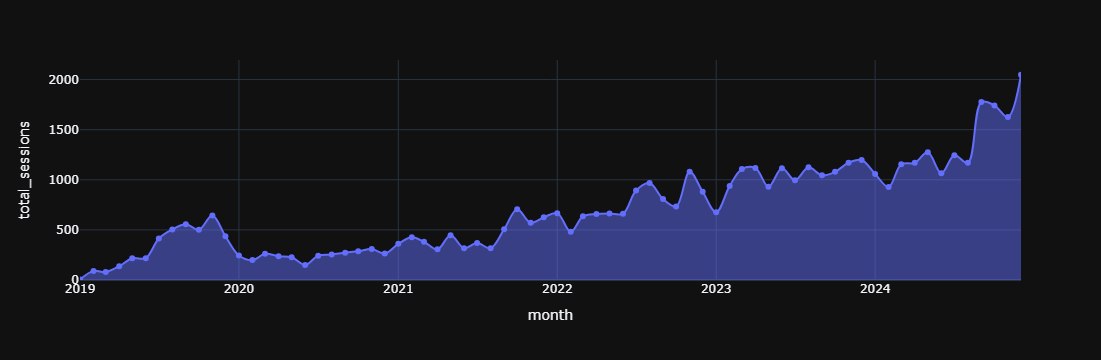

In [100]:
# Step 2: Allocate total session volume
TOTAL_SESSIONS = 50000
monthly_revenue["weight"] = monthly_revenue["revenue"] / monthly_revenue["revenue"].sum()
monthly_revenue["total_sessions"] = (monthly_revenue["weight"] * TOTAL_SESSIONS).astype(int)

fig_sessions = px.area(
    monthly_revenue,
    x="month", y="total_sessions", 
    markers=True, line_shape="spline", template="plotly_dark"
)
fig_sessions.show()

In [102]:
# Step 3: Map orders into months
orders_by_month = completed_orders[completed_orders["channel"] == "online"].copy()
orders_by_month["order_month"] = pd.to_datetime(orders_by_month["order_date"]).dt.to_period("M").astype(str)
orders_by_month.head()

,order_id,customer_id,order_date,product_id,size,status,fulfillment,location,channel,order_month
0,162,1070,2019-01-12,73,L,Completed,True,FL,online,2019-01
1,475,783,2019-02-01,249,L,Completed,True,TX,online,2019-02
2,475,783,2019-02-01,67,S,Completed,True,TX,online,2019-02
3,532,839,2019-02-05,249,XL,Completed,True,MA,online,2019-02
4,605,1061,2019-02-09,249,M,Returned,True,FL,online,2019-02


In [104]:
# # Step 4: Generate sessions
# session_data = []
# session_counter = 0

# for _, row in monthly_revenue.iterrows():
#     month = row["month"]
#     total_sessions = row["total_sessions"]

#     month_start = pd.to_datetime(f"{month}-01")
#     month_end = month_start + pd.offsets.MonthEnd(0)

#     orders_in_month = orders_by_month[orders_by_month["order_month"] == month]
#     num_orders = len(orders_in_month)

#     if num_orders == 0:
#         continue

#     avg_revenue_per_order = row["revenue"] / max(row["order_count"], 1)
#     sessions_for_orders = 0
#     sessions_for_non_buyers = total_sessions

#     for _, order_row in orders_in_month.iterrows():
#         order_time = pd.to_datetime(order_row["order_date"])
#         sources, weights = get_source_weights(order_time)

#         # Scale session count using avg revenue per order (bounded between 40–100)
#         base_sessions = total_sessions // (row["order_count"] + 1)
#         num_sessions = int(random.gauss(base_sessions, 5))
#         num_sessions = max(1, min(num_sessions, 120))  # safety bounds

#         if sessions_for_non_buyers < num_sessions:
#             # break
#             num_sessions = sessions_for_non_buyers
#             num_sessions = min(num_sessions, sessions_for_non_buyers)
#             num_sessions = max(1, num_sessions)

#         for i in range(num_sessions):
#             converted = (i == num_sessions - 1)
#             session_data.append({
#                 'session_id': f"{order_row['order_id']}_{i}",
#                 'customer_id': order_row['customer_id'],
#                 'order_id': order_row['order_id'] if converted else None,
#                 'source': np.random.choice(sources, p=weights),
#                 'timestamp': order_time - timedelta(days=random.randint(0, 14), hours=random.randint(0, 23)),
#                 'device': np.random.choice(['mobile', 'desktop'], p=[0.4, 0.6]),
#                 'page_views': random.randint(1, 10),
#                 'converted': converted
#             })
#             session_counter += 1
#         sessions_for_non_buyers -= num_sessions

#     for _ in range(sessions_for_non_buyers):
#         session_time = month_start + timedelta(
#             days=random.randint(0, (month_end - month_start).days),
#             hours=random.randint(0, 23)
#         )
#         sources, weights = get_source_weights(session_time)
#         session_data.append({
#             'session_id': f"fake_{session_counter}",
#             'customer_id': 200000 + session_counter,
#             'order_id': None,
#             'source': np.random.choice(sources, p=weights),
#             'timestamp': session_time,
#             'device': np.random.choice(['mobile', 'desktop'], p=[0.4, 0.6]),
#             'page_views': random.randint(1, 8),
#             'converted': False
#         })
#         session_counter += 1

# # Convert to DataFrame
# sessions_df = pd.DataFrame(session_data)


In [106]:
# Step 4: Generate sessions
session_data = []
session_counter = 0

for _, row in monthly_revenue.iterrows():
    month = row["month"]
    total_sessions = row["total_sessions"]
    month_start = pd.to_datetime(f"{month}-01")
    month_end = month_start + pd.offsets.MonthEnd(0)

    orders_in_month = orders_by_month[orders_by_month["order_month"] == month]
    num_orders = row["order_count"]
    if num_orders == 0:
        continue

    sessions_for_non_buyers = total_sessions

    for _, order_row in orders_in_month.iterrows():
        order_time = pd.to_datetime(order_row["order_date"])
        sources, weights = get_source_weights(order_time)
        order_value = orders_with_price[orders_with_price["order_id"] == order_row["order_id"]]["price"].sum()

        # Session count scaled by order value (bounded)
        # base_sessions = max(3, min(int(order_value / 100), 15))
        base_sessions = total_sessions * 0.015 / (row["order_count"] + 1) # conversion rate is 1.5%
        # base_sessions = np.random.choice([11, 12, 13, 14, 15], p=[0.1, 0.15, 0.2, 0.25, 0.3]) # around 12-15 sessions result in an order
            
        if sessions_for_non_buyers <= 0:
            break
        # num_sessions = min(base_sessions, sessions_for_non_buyers)
        num_sessions = int(random.gauss(base_sessions, 5))

        for i in range(num_sessions):
            converted = (i == num_sessions - 1)
            session_data.append({
                'session_id': f"{order_row['order_id']}_{i}",
                'customer_id': order_row['customer_id'],
                'order_id': order_row['order_id'] if converted else None,
                'source': np.random.choice(sources, p=weights),
                'timestamp': order_time - timedelta(days=random.randint(0, 14), hours=random.randint(0, 23)),
                'device': np.random.choice(['mobile', 'desktop'], p=[0.4, 0.6]),
                'page_views': random.randint(1, 10),
                'converted': converted
            })
            session_counter += 1
        sessions_for_non_buyers -= num_sessions

    # Simulate fake (non-converting) customers
    while sessions_for_non_buyers > 0:
        session_time = month_start + timedelta(
            days=random.randint(0, (month_end - month_start).days),
            hours=random.randint(0, 23)
        )
        sources, weights = get_source_weights(session_time)
        num_sessions = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 10], p=[0.2, 0.2, 0.2, 0.15, 0.1, 0.05, 0.04, 0.03, 0.03])
        for _ in range(min(num_sessions, sessions_for_non_buyers)):
            session_data.append({
                'session_id': f"fake_{session_counter}",
                'customer_id': 200000 + session_counter,
                'order_id': None,
                'source': np.random.choice(sources, p=weights),
                'timestamp': session_time,
                'device': np.random.choice(['mobile', 'desktop'], p=[0.4, 0.6]),
                'page_views': random.randint(1, 8),
                'converted': False
            })
            session_counter += 1
            sessions_for_non_buyers -= 1

# Convert to DataFrame
sessions_df = pd.DataFrame(session_data)


In [108]:
sessions_df['customer_id'].nunique()

49431

In [112]:
sessions_df.to_csv("sessions_data.csv", index=False)

C:\temp\ipykernel_36284\1821423631.py:19: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



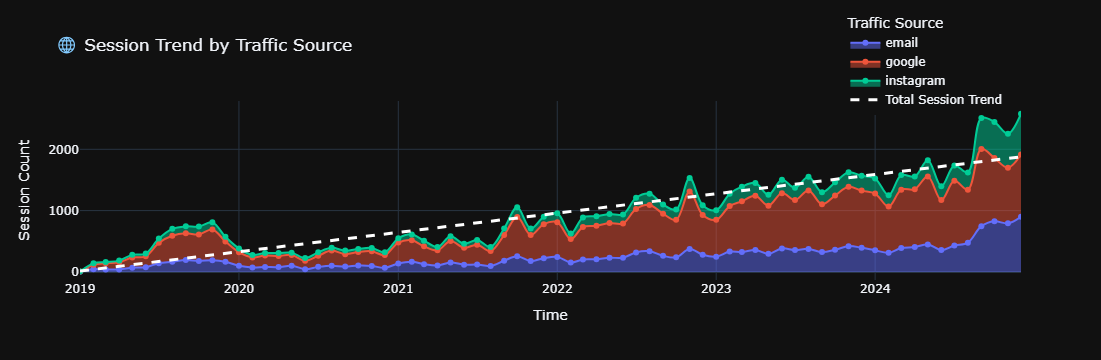

In [114]:
# Prepare session data
sessions_df["session_month"] = pd.to_datetime(sessions_df["timestamp"]).dt.to_period("M").astype(str)

# Compute session trends by traffic source
session_trend = sessions_df.groupby(["session_month", "source"])["session_id"].count().reset_index()
session_trend.rename(columns={"session_month": "session_date", "session_id": "sessions"}, inplace=True)

# Create area chart
fig_sessions = px.area(
    session_trend,
    x="session_date", y="sessions", color="source",
    title="🌐 Session Trend by Traffic Source",
    markers=True, line_shape="spline", template="plotly_dark",
    labels={"sessions": "Session Count", "session_date": "Time", "source": "Traffic Source"}
)

# Add total session trend line
total_session_trend = session_trend.groupby("session_date")["sessions"].sum().reset_index()
total_session_trend["numeric_date"] = pd.to_datetime(total_session_trend["session_date"]).view('int64') // 10**9

model = LinearRegression()
X = total_session_trend[["numeric_date"]]
y = total_session_trend["sessions"]
model.fit(X, y)
total_session_trend["trend"] = model.predict(X)

fig_sessions.add_trace(
    go.Scatter(
        x=total_session_trend["session_date"],
        y=total_session_trend["trend"],
        mode="lines",
        name="Total Session Trend",
        line=dict(color="white", width=3, dash="dash")
    )
)

fig_sessions.update_layout(
    legend=dict(
        orientation="v",
        y=1.5,
        x=0.9,
        xanchor="center"
    )
)

fig_sessions.show()


-------

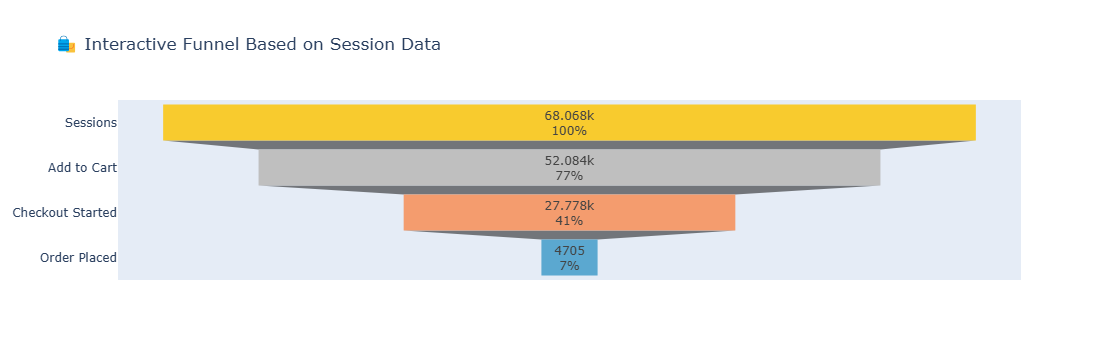

In [121]:
import pandas as pd
import plotly.graph_objects as go

# Load your file
sessions_df = pd.read_csv("sessions_data.csv")
sessions_df["converted"] = sessions_df["converted"].astype(bool)
sessions_df["has_cart"] = sessions_df["page_views"] >= 3
sessions_df["checkout_started"] = sessions_df["page_views"] >= 6

funnel_counts = {
    "Sessions": len(sessions_df),
    # "Product Views": sessions_df[sessions_df["page_views"] >= 1].shape[0],
    "Add to Cart": sessions_df[sessions_df["has_cart"]].shape[0],
    "Checkout Started": sessions_df[sessions_df["checkout_started"]].shape[0],
    "Order Placed": sessions_df[sessions_df["converted"]].shape[0]
}

fig = go.Figure(go.Funnel(
    y=list(funnel_counts.keys()),
    x=list(funnel_counts.values()),
    textinfo="value+percent initial",
    marker={"color": ["#f8cb2e", "#bfbfbf", "#f49c6e", "#5ba8d0", "#4b8bbe"]}
))

fig.update_layout(title="🛍️ Interactive Funnel Based on Session Data")
fig.show()


In [119]:
sessions_df.head()

,session_id,customer_id,order_id,source,timestamp,device,page_views,converted,session_month,has_cart,checkout_started
0,fake_0,200000,NaN,email,2019-01-07 05:00:00,desktop,6,False,2019-01,True,True
1,fake_1,200001,NaN,instagram,2019-01-25 01:00:00,desktop,2,False,2019-01,False,False
2,fake_2,200002,NaN,instagram,2019-01-25 01:00:00,mobile,4,False,2019-01,True,False
3,fake_3,200003,NaN,google,2019-01-25 01:00:00,desktop,6,False,2019-01,True,True
4,fake_4,200004,NaN,google,2019-01-06 00:00:00,desktop,1,False,2019-01,False,False
